In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Performing Text Analysis on the data to know more about the data
# Creating a Data Frame for the DataSet
df = pd.read_csv('/content/NN_Email_Spams.csv', encoding='latin1')
print(df)

       label                                               text
0          1  ounce feather bowl hummingbird opec moment ala...
1          1  wulvob get your medircations online qnb ikud v...
2          0   computer connection from cnn com wednesday es...
3          1  university degree obtain a prosperous future m...
4          0  thanks for all your answers guys i know i shou...
...      ...                                                ...
83443      0  hi given a date how do i get the last date of ...
83444      1  now you can order software on cd or download i...
83445      1  dear valued member canadianpharmacy provides a...
83446      0  subscribe change profile contact us long term ...
83447      1  get the most out of life ! viagra has helped m...

[83448 rows x 2 columns]


In [3]:
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [4]:
df.columns

Index(['label', 'text'], dtype='object')

In [5]:
df.describe()

,label
count,83448.000000
mean,0.526196
std,0.499316
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
# Checking the number of null values present
df.isnull().sum()

,0
label,0
text,0


In [7]:
#'1' indicates that the email is classified as spam.
#'0' denotes that the email is legitimate (ham).
df['label'].value_counts()

,count
label,
1,43910
0,39538


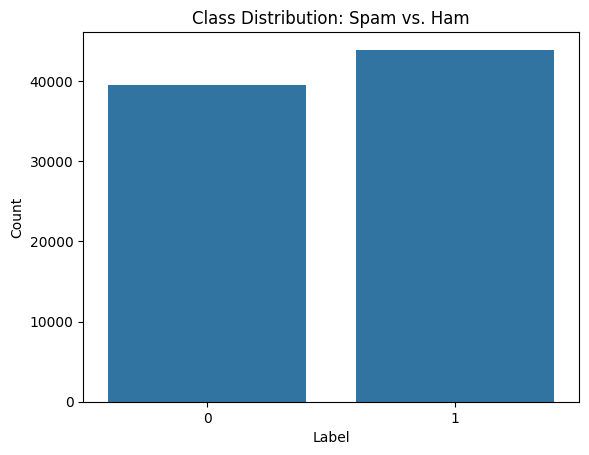

In [8]:
import seaborn as sns

# Plotting the class distribution
sns.countplot(x='label', data=df)
plt.title('Class Distribution: Spam vs. Ham')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [9]:
# Text Cleaning: Removing Special characters, lowercasing texts & eliminating whitespaces.
import re

def filtered_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    text = ' '.join(text.split())
    return text

df['text'] = df['text'].apply(filtered_text)

In [10]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [11]:
def generate_USE_embeddings(texts, batch_size=100):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        embeddings_batch = embed(batch_texts).numpy()
        embeddings.append(embeddings_batch)
    return np.vstack(embeddings)

# Generating USE embeddings for text in batches
# Utilizing batches to reduce longer run times
texts = df['text'].tolist()
X_USE_embeddings = generate_USE_embeddings(texts, batch_size=100)

y = df['label'].values

In [12]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Loading pretrained BERT model
pretrained_bert_model = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_bert_model)
model = AutoModel.from_pretrained(pretrained_bert_model)

# In order to avoid RAM crashes use GPU via cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_BERT_embeddings(texts, batch_size=100):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
        # Utilizing the [CLS] token embedding for classification
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

# Generating BERT embeddings for text in batches
# Utilizing batches to reduce longer run times
texts = df['text'].tolist()
X_BERT_embeddings = generate_BERT_embeddings(texts, batch_size=100)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Train-test Split 80/20
X_train_USE, X_test_USE, y_train_USE, y_test_USE = train_test_split(X_USE_embeddings, y, test_size=0.2, random_state=42)

# Assigning class weights to handle slightly imbalanced classes
# Creating the Logistic Regression model for USE
class_weights = {0: 1, 1: 2}
lr_model_USE = LogisticRegression(max_iter=1000, class_weight=class_weights)

# Generating 5 fold cross-validation scores to examine the model's performance
cv_scores = cross_val_score(lr_model_USE, X_train_USE, y_train_USE, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

# Model Training
lr_model_USE.fit(X_train_USE, y_train_USE)

# Predict on the test set
y_pred_lr_USE = lr_model_USE.predict(X_test_USE)

Cross-validation scores: [0.96120431 0.96330138 0.9613541  0.95985319 0.96090181]
Mean CV score: 0.9613229591821393


USE Based Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      7938
           1       0.95      0.98      0.96      8752

    accuracy                           0.96     16690
   macro avg       0.96      0.96      0.96     16690
weighted avg       0.96      0.96      0.96     16690



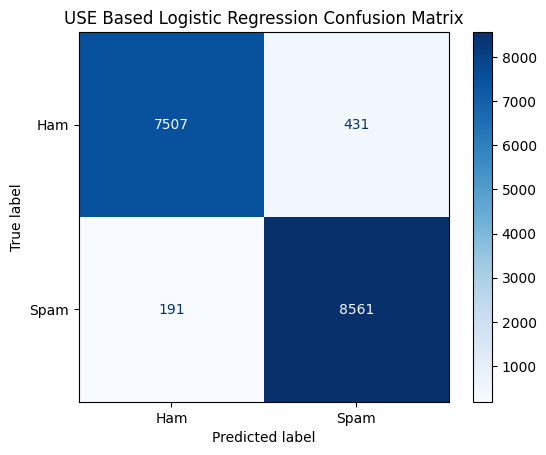

USE Based Logistic Regression Accuracy: 0.96


In [14]:
# Classification Report
print("USE Based Logistic Regression Classification Report:")
print(classification_report(y_test_USE, y_pred_lr_USE))

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_lr_USE = confusion_matrix(y_test_USE, y_pred_lr_USE)
disp_lr_USE = ConfusionMatrixDisplay(confusion_matrix=cm_lr_USE, display_labels=['Ham', 'Spam'])
disp_lr_USE.plot(cmap='Blues')
plt.title('USE Based Logistic Regression Confusion Matrix')
plt.show()

# Accuracy of Logistic Regression
accuracy_lr_USE = accuracy_score(y_test_USE, y_pred_lr_USE)
print(f"USE Based Logistic Regression Accuracy: {accuracy_lr_USE:.2f}")

In [15]:
# Train-test Split 80/20
X_train_BERT, X_test_BERT, y_train_BERT, y_test_BERT = train_test_split(X_BERT_embeddings, y, test_size=0.2, random_state=42)

# Assigning class weights to handle slightly imbalanced classes
# Creating the Logistic Regression model for BERT
lr_model_BERT = LogisticRegression(max_iter=1000, class_weight=class_weights)

# Model Training
lr_model_BERT.fit(X_train_BERT, y_train_BERT)

# Predict on the test set
y_pred_lr_BERT = lr_model_BERT.predict(X_test_BERT)

BERT Based Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7938
           1       0.96      0.98      0.97      8752

    accuracy                           0.97     16690
   macro avg       0.97      0.97      0.97     16690
weighted avg       0.97      0.97      0.97     16690



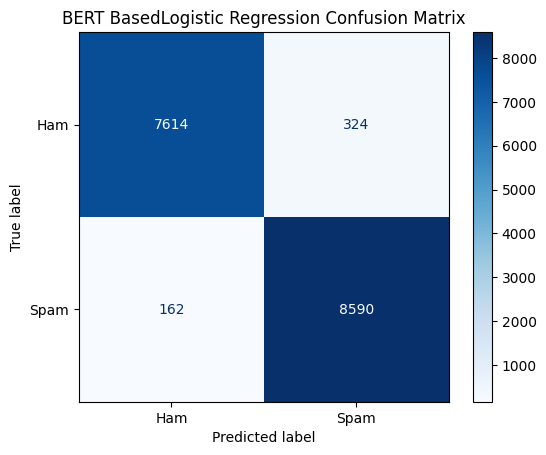

BERT Based Logistic Regression Accuracy: 0.97


In [16]:
# Classification Report
print("BERT Based Classification Report:")
print(classification_report(y_test_BERT, y_pred_lr_BERT))

# Confusion matrix
cm_lr_BERT = confusion_matrix(y_test_BERT, y_pred_lr_BERT)
disp_lr_BERT = ConfusionMatrixDisplay(confusion_matrix=cm_lr_BERT, display_labels=['Ham', 'Spam'])
disp_lr_BERT.plot(cmap='Blues')
plt.title('BERT BasedLogistic Regression Confusion Matrix')
plt.show()

# Accuracy of Logistic Regression with BERT
accuracy_lr_BERT = accuracy_score(y_test_BERT, y_pred_lr_BERT)
print(f"BERT Based Logistic Regression Accuracy: {accuracy_lr_BERT:.2f}")

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

# Train-test Split 80/20
X_train_USE, X_test_USE, y_train_USE, y_test_USE = train_test_split(X_USE_embeddings, y, test_size=0.2, random_state=42)

# Computing class weights for slightly imbalanced dataset
class_weights_USE = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_USE), y=y_train_USE)
class_weight_dict_USE = {0: class_weights_USE[0], 1: class_weights_USE[1]}

# USE Based Neural Network Creation
nn_model_USE = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_USE.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

nn_model_USE.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_USE = nn_model_USE.fit(
    X_train_USE, y_train_USE,
    epochs=10, batch_size=32, validation_split=0.2,
    class_weight=class_weight_dict_USE
)

y_pred_nn_USE = (nn_model_USE.predict(X_test_USE) > 0.5).astype("int32")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9361 - loss: 0.1721 - val_accuracy: 0.9756 - val_loss: 0.0748
Epoch 2/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9815 - loss: 0.0548 - val_accuracy: 0.9794 - val_loss: 0.0626
Epoch 3/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9863 - loss: 0.0415 - val_accuracy: 0.9797 - val_loss: 0.0630
Epoch 4/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9887 - loss: 0.0338 - val_accuracy: 0.9820 - val_loss: 0.0609
Epoch 5/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9923 - loss: 0.0242 - val_accuracy: 0.9827 - val_loss: 0.0593
Epoch 6/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9942 - loss: 0.0199 - val_accuracy: 0.9834 - val_loss: 0.0563
Epoch 7/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9944 - loss: 0.0180 - val_accuracy: 0.9823 - val_loss: 0.0696
Epoch 8/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9932 - loss: 0.0194 - 

USE Based Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7938
           1       0.99      0.98      0.99      8752

    accuracy                           0.98     16690
   macro avg       0.98      0.98      0.98     16690
weighted avg       0.98      0.98      0.98     16690



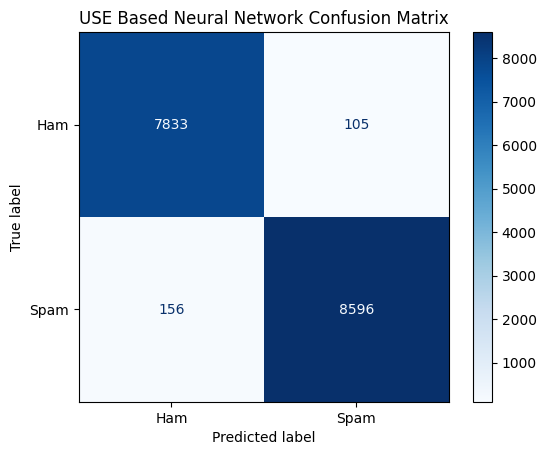

USE Based Neural Network Accuracy: 0.98


In [18]:
print("USE Based Neural Network Classification Report:")
print(classification_report(y_test_USE, y_pred_nn_USE))

# Confusion Matrix for Neural Network USE
cm_nn_USE = confusion_matrix(y_test_USE, y_pred_nn_USE)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn_USE, display_labels=['Ham', 'Spam'])
disp_nn.plot(cmap='Blues')
plt.title('USE Based Neural Network Confusion Matrix')
plt.show()

# Accuracy of Neural Network USE
accuracy_nn_USE = accuracy_score(y_test_USE, y_pred_nn_USE)
print(f"USE Based Neural Network Accuracy: {accuracy_nn_USE:.2f}")

In [19]:
# Train-test Split 80/20
X_train_BERT, X_test_BERT, y_train_BERT, y_test_BERT = train_test_split(X_BERT_embeddings, y, test_size=0.2, random_state=42)

# Computing class weights for slightly imbalanced dataset
class_weights_BERT = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_BERT), y=y_train_BERT)
class_weight_dict_BERT = {0: class_weights_BERT[0], 1: class_weights_BERT[1]}

# BERT Neural Network
nn_model_BERT = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_BERT.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model_BERT.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_BERT = nn_model_BERT.fit(
    X_train_BERT, y_train_BERT,
    epochs=10, batch_size=32, validation_split=0.2,
    class_weight=class_weight_dict_BERT
)

y_pred_nn_BERT = (nn_model_BERT.predict(X_test_BERT) > 0.5).astype("int32")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9186 - loss: 0.1956 - val_accuracy: 0.9670 - val_loss: 0.0932
Epoch 2/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9634 - loss: 0.0972 - val_accuracy: 0.9724 - val_loss: 0.0827
Epoch 3/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9692 - loss: 0.0824 - val_accuracy: 0.9742 - val_loss: 0.0765
Epoch 4/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9750 - loss: 0.0717 - val_accuracy: 0.9754 - val_loss: 0.0715
Epoch 5/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9778 - loss: 0.0633 - val_accuracy: 0.9775 - val_loss: 0.0699
Epoch 6/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9796 - loss: 0.0583 - val_accuracy: 0.9760 - val_loss: 0.0678
Epoch 7/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9809 - loss: 0.0569 - val_accuracy: 0.9770 - val_loss: 0.0681
Epoch 8/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9808 - loss: 0.0540 - 

BERT Based Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7938
           1       0.98      0.99      0.98      8752

    accuracy                           0.98     16690
   macro avg       0.98      0.98      0.98     16690
weighted avg       0.98      0.98      0.98     16690



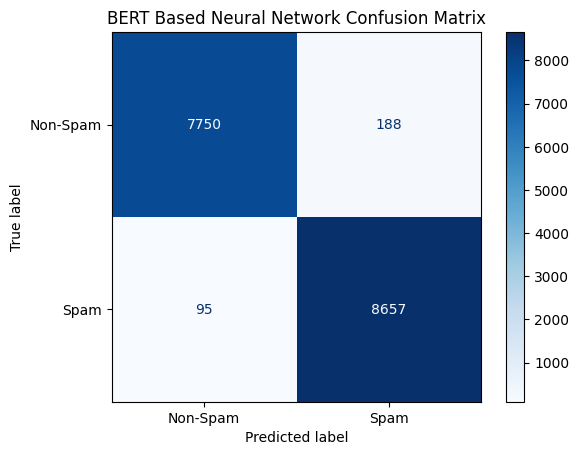

BERT Based Neural Network Accuracy: 0.98


In [20]:
print("BERT Based Neural Network Classification Report:")
print(classification_report(y_test_BERT, y_pred_nn_BERT))

# Confusion Matrix for Neural Network BERT
cm_nn_BERT = confusion_matrix(y_test_BERT, y_pred_nn_BERT)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn_BERT, display_labels=['Non-Spam', 'Spam'])
disp_nn.plot(cmap='Blues')
plt.title('BERT Based Neural Network Confusion Matrix')
plt.show()

# Accuracy of Neural Network BERT
accuracy_nn_BERT = accuracy_score(y_test_BERT, y_pred_nn_BERT)
print(f"BERT Based Neural Network Accuracy: {accuracy_nn_BERT:.2f}")

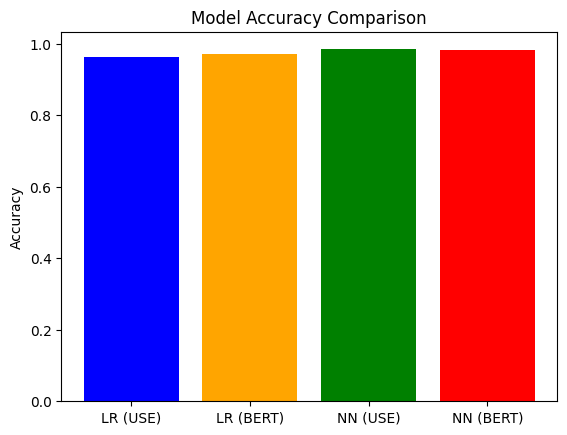

In [34]:
# Comparing the accuracy of different models with different embeddings
accuracies = [accuracy_lr_USE, accuracy_lr_BERT, accuracy_nn_USE, accuracy_nn_BERT]
labels = ['LR (USE)', 'LR (BERT)', 'NN (USE)', 'NN (BERT)']

plt.bar(labels, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

In [35]:
# Preprocessing user input
def preprocess_text(text):
    text = text.lower()
    return text

# Applying USE embedding
def get_USE_embedding(text):
    preprocessed_text = preprocess_text(text)
    embedding = embed([preprocessed_text]).numpy()
    return embedding

# Applying BERT embedding
def get_BERT_embedding(text):
    preprocessed_text = preprocess_text(text)
    inputs = tokenizer([preprocessed_text], return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embedding

In [36]:
# Prediction for USE based Logistic Regression Model
def predict_with_lr_USE(text, lr_model_USE, embedding_type="USE"):
    if embedding_type == "USE":
        text_embedding = get_USE_embedding(text)
    else:
        raise ValueError("Invalid embedding_type.")

    prediction = lr_model_USE.predict(text_embedding)

    return "Spam" if prediction == 1 else "Ham"

In [37]:
# Prediction for BERT based Logistic Regression Model
def predict_with_lr_BERT(text, lr_model_BERT, embedding_type="BERT"):
    if embedding_type == "BERT":
        text_embedding = get_BERT_embedding(text)
    else:
        raise ValueError("Invalid embedding_type.")

    prediction = lr_model_BERT.predict(text_embedding)

    return "Spam" if prediction == 1 else "Ham"

In [38]:
# Prediction for USE based Neural Network Model
def predict_with_nn_USE(text, nn_model_USE, embedding_type="USE"):
    if embedding_type == "USE":
        text_embedding = get_USE_embedding(text)
    else:
        raise ValueError("Invalid embedding_type.")

    prediction = nn_model_USE.predict(text_embedding)

    return "Spam" if (prediction > 0.5) else "Ham"

In [39]:
# Prediction for BERT based Neural Network Model
def predict_with_nn_BERT(text, nn_model_BERT, embedding_type="USE"):
    if embedding_type == "BERT":
        text_embedding = get_BERT_embedding(text)
    else:
        raise ValueError("Invalid embedding_type.")

    prediction = nn_model_BERT.predict(text_embedding)

    return "Spam" if (prediction > 0.5) else "Ham"

In [41]:
#Taking input from the user
user_input = input("Enter the text (email/message) to classify as Spam or Ham: ")

# Logistic Regression Predictions
lr_prediction_USE = predict_with_lr_USE(user_input, lr_model_USE, embedding_type="USE")
lr_prediction_BERT = predict_with_lr_BERT(user_input, lr_model_BERT, embedding_type="BERT")

print("Logistic Regression Prediction (USE):", lr_prediction_USE)
print("Logistic Regression Prediction (BERT):", lr_prediction_BERT)

# Neural Network Predictions
nn_prediction_USE = predict_with_nn_USE(user_input, nn_model_USE, embedding_type="USE")
nn_prediction_BERT = predict_with_nn_BERT(user_input, nn_model_BERT, embedding_type="BERT")

print("Neural Network Prediction (USE):", nn_prediction_USE)
print("Neural Network Prediction (BERT):", nn_prediction_BERT)

Enter the text (email/message) to classify as Spam or Ham: Congratulations, you have successfully logged in
Logistic Regression Prediction (USE): Spam
Logistic Regression Prediction (BERT): Spam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Neural Network Prediction (USE): Ham
Neural Network Prediction (BERT): Ham
